# 1. 시계열 분석(다변량)

## 1-1. 데이터의 적합성 및 정상성을 판단하시오.

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('DailyDelhiClimateTrain.csv').iloc[:-1, :]
test = pd.read_csv('DailyDelhiClimateTest.csv')

In [3]:
train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
test.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


data가 1일 간격으로 생성된 것을 확인할 수 있다.

In [5]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [6]:
train.set_index('date', inplace = True)
test.set_index('date', inplace = True)

In [7]:
train = train.asfreq(freq = 'D')
test = test.asfreq(freq = 'D')

In [8]:
train

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-27,16.850000,67.550000,8.335000,1017.200000
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

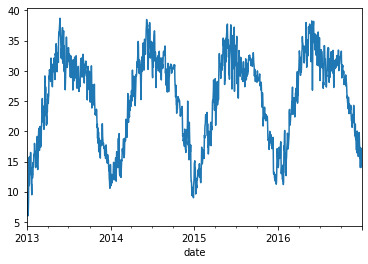

In [10]:
train.iloc[:,0].plot()
plt.show()

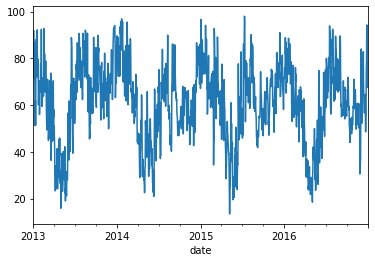

In [11]:
train.iloc[:,1].plot()
plt.show()

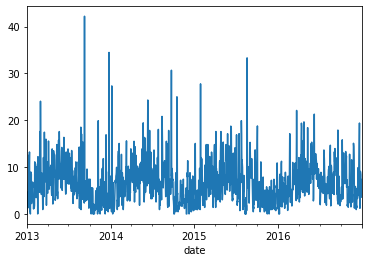

In [12]:
train.iloc[:,2].plot()
plt.show()

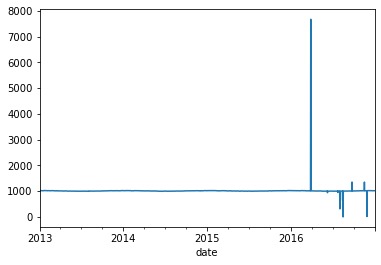

In [13]:
train.iloc[:,3].plot()
plt.show()

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.vector_ar.var_model import VAR

In [15]:
def stationary_test(df, columns,treshold = 0.05):

    for c in columns:

        time_series = df[c][df[c].notnull()]
        fig, ax = plt.subplots(1,2, figsize = (10,6))
        plt.suptitle(f'{c}', size = 20)
        plot_acf(time_series,title = f'ACF - {c}', ax = ax[0])
        plot_pacf(time_series, title = f'PACF - {c}', ax = ax[1])
        plt.xlabel('lags')
        plt.show()

        dickley_fuller_test = adfuller(time_series)
        a_pvalue = dickley_fuller_test[1]
        
        kpss_test = kpss(time_series)
        k_pvalue = kpss_test[1]

        if a_pvalue < treshold:
            print(f'Time series "{c}" is stationay (NULL HP rejected - pvalue = {a_pvalue})')
        else:
            print(f'Time series "{c}" might have unit root (NULL HP cannot be rejected - pvalue = {a_pvalue})')
        if k_pvalue < treshold:
            print(f'Time series "{c}" is stationay (NULL HP rejected - pvalue = {k_pvalue})')
        else:
            print(f'Time series "{c}" might have unit root (NULL HP cannot be rejected - pvalue = {k_pvalue})')

In [1]:
#stationary_test(train, train.columns)

meantemp가 정상성을 만족하지 못하므로 차분을 진행한다.

In [17]:
tr_diff_mt = train.meantemp[-1]
train['diff_meantemp'] = train.meantemp.diff(1)
train.dropna(inplace = True)

In [2]:
#stationary_test(train.iloc[:,1:], train.columns[1:])

전부 정상성을 만족한다. 

## 1-2. 시계열 분석 기법 3가지를 각각 소개하고 기법들을 활용하여 test세트로 예측을 수행하시오.
- 모든 feature 예측값 출력

In [19]:
cols = ['humidity', 'wind_speed', 'meanpressure', 'diff_meantemp']

In [20]:
endog = train[cols]

In [21]:
dates = endog.index

### 1) VAR(Vector Auto Regression)

In [24]:
import numpy as np

In [25]:
forecasting_model = VAR(endog, dates = dates, freq = 'D')
results_aic = []
for p in range(1,10):
    results = forecasting_model.fit(p)
    results_aic.append(results.aic)

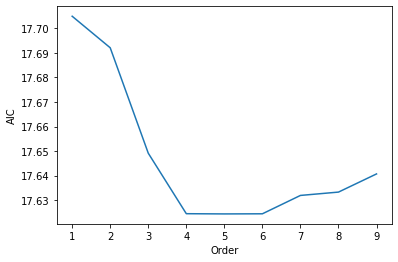

In [26]:
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [27]:
results_aic

[17.70490834523937,
 17.692068334397053,
 17.649146437096007,
 17.624506543610053,
 17.624417294648996,
 17.624467115168176,
 17.63194423989471,
 17.633304686416334,
 17.640702977052044]

In [28]:
var = VAR(endog, dates = dates, freq = 'D')

In [29]:
var_result = var.fit(maxlags = 4, ic = 'aic', verbose = 1)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 4, BIC -> 1, FPE -> 4, HQIC -> 4>
Using 4 based on aic criterion


In [30]:
te_diff_mt = test['meantemp'][-1]
for_steps = test.shape[0]
for_index = test.index
test_diff = test.copy()
test_diff['diff_meantemp'] = test_diff['meantemp'].diff(1)
test_diff.dropna(inplace = True)

In [31]:
var_forcasted = var_result.forecast(train[cols].values[-4:], for_steps)

In [32]:
var_df = pd.DataFrame(var_forcasted, columns = cols, index = for_index)

In [33]:
var_df['meantemp'] = tr_diff_mt + var_df['diff_meantemp'].cumsum()

In [34]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [35]:
cols[3] = 'meantemp'

In [36]:
for c in cols :
    print(f'RMSE of {c} = {np.sqrt(mean_squared_error(test[c], var_df[c]))}')

RMSE of humidity = 17.80371148592949
RMSE of wind_speed = 3.8290818532869673
RMSE of meanpressure = 92.32154081300835
RMSE of meantemp = 7.464358732409516


In [37]:
var_df

,humidity,wind_speed,meanpressure,diff_meantemp,meantemp
date,,,,,
2017-01-01,82.099601,5.786990,1041.752322,0.361086,15.413717
2017-01-02,79.970499,5.962300,988.115666,0.288809,15.702526
2017-01-03,79.366637,6.010135,1002.584677,0.017947,15.720474
2017-01-04,79.524336,5.764507,1001.586410,-0.005596,15.714878
2017-01-05,78.583862,5.676823,1007.998489,0.078934,15.793812
...,...,...,...,...,...
2017-04-20,60.711726,6.822748,1011.068105,0.006058,17.768607
2017-04-21,60.709242,6.822928,1011.068561,0.006047,17.774654
2017-04-22,60.706894,6.823098,1011.068992,0.006036,17.780690


In [43]:
from statsmodels.tsa.statespace.varmax import VARMAX

### 2) SARIMA

In [38]:
import itertools
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [67]:
def get_pred(data) :
    cols = data.columns.tolist()
    df = pd.DataFrame()
    for c in range(len(cols)) :
        
        p, q = range(1,3), range(1,3)
        d = range(0,1)
        P, Q = range(1,3), range(1,3)
        D = range(1,2)
        m = 12
        trend_pdq = list(itertools.product(p, d, q))
        seasonal_pdq = [(candi[0], candi[1], candi[2], m) for candi in list(itertools.product(P, D, Q))]
        ## SARIMAX
        AIC = []
        SARIMAX_order = []
        for trend_param in tqdm(trend_pdq):
            for seasonal_params in seasonal_pdq:
                try:
                    result = SARIMAX(data[cols[c]], trend = 'c', 
                                           order = trend_param, seasonal_order = seasonal_params,
                                     exog = data.drop(cols[c], axis = 1)).fit()
                    AIC.append(result.aic)
                    SARIMAX_order.append([trend_param, seasonal_params])
                except:
                    continue
        print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_order[AIC.index(min(AIC))][0],
                                                                     SARIMAX_order[AIC.index(min(AIC))][1]))
        
        fit_ts_sarimax = SARIMAX(data[cols[c]], trend = 'c', order = SARIMAX_order[AIC.index(min(AIC))][0], 
                                seasonal_order = SARIMAX_order[AIC.index(min(AIC))][1],
                                        exog = data.drop(cols[c], axis = 1)).fit()
        pred = fit_ts_sarimax.get_prediction(start = for_index[0], end = for_index[-1],
                                     exog = data.drop(cols[c], axis = 1).values[-for_steps:])
        pred = pred.predicted_mean
        df[cols[c]] = pred
        plt.title(f'{cols[c]}', size = 15)
        fit_ts_sarimax.plot_diagnostics(figsize = (16,10))
        plt.show()
    return df

In [3]:
#sarima_df = get_pred(train.iloc[:, 1:])
#sarima_df
### 그래프랑 최종 예측 결과 데이터프레임 나옴

In [69]:
sarima_df['meantemp'] = tr_diff_mt + sarima_df['diff_meantemp'].cumsum()

In [70]:
sarima_df

,humidity,wind_speed,meanpressure,diff_meantemp,meantemp
2017-01-01,86.748495,10.526531,1009.844017,-0.085136,14.967495
2017-01-02,78.449881,9.682451,1007.866971,-0.031202,14.936293
2017-01-03,79.455957,8.914722,1004.278528,-0.004787,14.931506
2017-01-04,77.390252,8.203664,1011.455595,-0.173334,14.758172
2017-01-05,78.147833,7.743537,1001.537909,0.303997,15.062169
...,...,...,...,...,...
2017-04-20,58.748333,6.278469,1012.170237,0.001154,8.654235
2017-04-21,58.751864,5.789058,1007.570613,-0.021379,8.632856
2017-04-22,62.791560,3.655993,1016.640661,-0.307301,8.325556
2017-04-23,61.215532,2.451952,1003.379775,0.013451,8.339007


## 1-3. 각 기법별로 사후 분석을 수행하시오.

In [75]:
np.sqrt(mean_squared_error(test[cols], var_df[cols]))

47.19803375112001

In [76]:
np.sqrt(mean_squared_error(test[cols], sarima_df[cols]))

46.687905133460376

SARIMAX의 성능이 더 우수한 것으로 나타났다.

In [5]:
var_result.summary()

In [4]:
results.plot_forecast(114)
plt.show()

# 2. 회귀분석
- 예측대상 = value

## 2-1. 데이터를 전처리 한 후 시각화를 진행하고 해석하시오.

In [2]:
data = pd.read_csv("FIFA.csv", encoding = 'cp949')

In [3]:
data.head()

,ID,Name,Age,Nationality,Overall,Club,Preferred_Foot,Work_Rate,Position,Jersey_Number,Contract_Valid_Until,Height,Weight_lb,Release_Clause,Value,Wage
0,158023,L. Messi,31,Argentina,94,FC Barcelona,Left,Medium/ Medium,RF,10,2021,5'7,159,226500,110500,565
1,20801,Cristiano Ronaldo,33,Portugal,94,Juventus,Right,High/ Low,ST,7,2022,6'2,183,127100,77000,405
2,190871,Neymar Jr,26,Brazil,92,Paris Saint-Germain,Right,High/ Medium,LW,10,2022,5'9,150,228100,118500,290
3,193080,De Gea,27,Spain,91,Manchester United,Right,Medium/ Medium,GK,1,2020,6'4,168,138600,72000,260
4,192985,K. De Bruyne,27,Belgium,91,Manchester City,Right,High/ High,RCM,7,2023,5'11,154,196400,102000,355


In [4]:
def get_position(x) :
    if x.endswith('M') :
        return 'MF'
    elif x.endswith('B') :
        return 'DF'
    elif x == 'GK' :
        return 'GK'
    else :
        return 'FW'

In [5]:
data['pos'] = data['Position'].apply(get_position)

In [6]:
data['Height'] = data['Height'].str.replace("'", '.').astype(float)

In [7]:
data['Height'] *= 30.48
data['Weight_lb'] *= 0.453592

In [8]:
import seaborn as sns

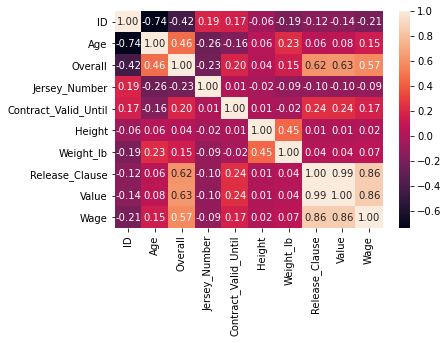

In [11]:
sns.heatmap(data.corr(), annot = True, fmt = '.2f')
plt.show()

Release_Clause는 value와 상관관계가 너무 높아 삭제한다.

In [12]:
data.drop('Release_Clause', axis = 1, inplace = True)

In [13]:
q1 = data.Wage.quantile(.25)
q3 = data.Wage.quantile(.75)

In [14]:
q = q3 - q1

In [15]:
q3 + 1.5 * q

18.5

In [16]:
q1 - 1.5 * q

-9.5

In [17]:
data = data[data.Wage < q3 + 1.5 * q]

<AxesSubplot:xlabel='Wage', ylabel='Density'>

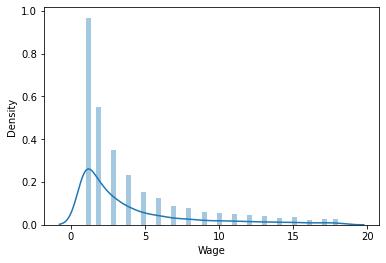

In [18]:
sns.distplot(data.Wage)

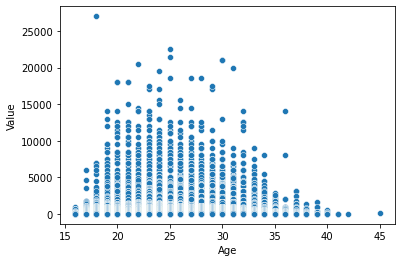

In [19]:
sns.scatterplot(data.Age, data.Value)
plt.show()

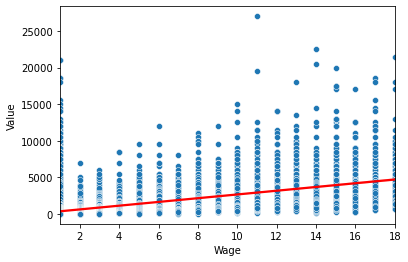

In [20]:
sns.scatterplot(data.Wage, data.Value)
sns.regplot(data.Wage, data.Value, color = 'r', scatter = False)
plt.show()

In [22]:
print(data[(data.Age < 20) & (data.Value > 50000)].index)
print(data[(data.Age < 30) & (data.Value > 80000)].index)
print(data[(data.Age > 30) & (data.Value > 60000)].index)
print(data[data.Age > 40].index)
print(data[(data.Wage < 300) & (data.Value > 80000)].index)

Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([4308, 6532, 9529, 13988], dtype='int64')
Int64Index([], dtype='int64')


In [23]:
data = data.query("index not in [4308,6532,9529,13988]")

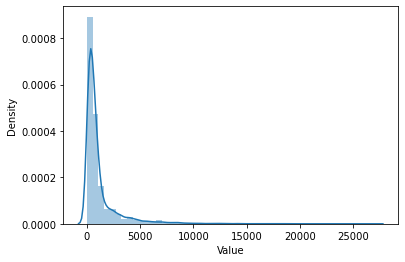

In [24]:
sns.distplot(data['Value'])
plt.show()

이적료가 대부분 20000 이하에 분포되어 있으며 이상치도 존재하는 것으로 나타났다.

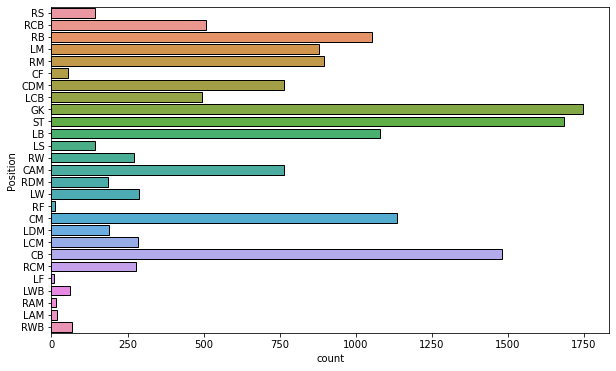

In [25]:
plt.figure(figsize = (10, 6))
sns.countplot(y = data.Position, edgecolor = (0, 0, 0))
plt.show()

ST, GK, CB, CM 순으로 선수들이 많은 것을 알 수 있다.

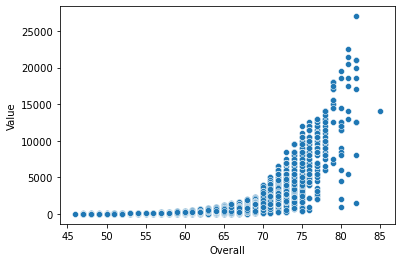

In [26]:
sns.scatterplot(data.Overall, data.Value)
plt.show()

선수 개인 기량이 뛰어날수록 이적료가 높은 것으로 나타났다.

## 2-2. 변수 선택법 중 하나를 택하여 최적의 회귀 모형을 탐색한 후 추정된 회귀식을 해석하시오.

In [27]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [28]:
y = data.Value
X = data[['Age', 'Overall', 'Contract_Valid_Until', 'Height', 'pos', 'Wage', 'Weight_lb']]
X = sm.add_constant(X)

In [104]:
X = pd.get_dummies(columns = ['pos'], data = X)

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [33]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(X.drop('pos', axis = 1).values, i)} 
             for i, column in enumerate(X.drop('pos', axis =1 ).columns.tolist())
             if column != 'const')  # 절편의 VIF는 구하지 않는다.

,컬럼,VIF
0,Age,1.474779
1,Overall,2.177902
2,Contract_Valid_Until,1.075918
3,Height,1.249484
4,Wage,1.714767
5,Weight_lb,1.318628


In [44]:
ols('Value ~ C(pos) + Wage + Overall + Height', data = data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     2175.
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        22:49:32   Log-Likelihood:            -1.2451e+05
No. Observations:               14494   AIC:                         2.490e+05
Df Residuals:                   14487   BIC:                         2.491e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -9123.8841    205.392    -44.422      0.000   -9526.479   -8721.289
C(pos)[T.FW]   279.9345     31.908      8.773      0.000     217.390     342.479
C(pos)[T.GK]    99.1748     37.439      2.649      0.008      25.790     172.560
C(pos)[T.MF]   301.7444     26.391     11.434      0.000     250.014     353.474
Wage           111.9688      3.523     31.786      0.000     105.064     118.874
Overall        150.7820      2.401     62.789      0.000     146.075     155.489
Height          -0.5636      0.844     -0.668      0.504      -2.218       1.091
==============================================================================
Omnibus:                    13861.730   Durbin-Watson:                   0.597
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           976627.616
Skew:                           4.511   Prob(JB):                         0.00
Kurtosis:                      42.189   Cond. No.                     3.58e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [107]:
add_feature = ['const']
aic_list = []
target_cols = X.columns[1:].tolist()
i = 0
while True :
    i += 1
    print(f'\n{i}번째 탐색')
    if i == 1 :
        
        before_model = sm.OLS(y, X[['const']]).fit()
        before_aic = before_model.aic
        print(f'변수 추가 전 AIC는 {before_aic}')
        for c in target_cols :
            after_model = sm.OLS(y, X[add_feature + [c]]).fit()
            after_aic = after_model.aic
            print(f'{c} 추가 되었을 때 AIC는 {round(after_aic, 4)}')
            aic_list.append(after_aic)
        print(f'추가될 변수는 {target_cols[np.argmin(aic_list)]}')
        add_feature.append(target_cols[np.argmin(aic_list)])
        
        target_cols.pop(np.argmin(aic_list))
        print(1)
    elif i != 1 :
        a = []
        before_model = sm.OLS(y, X[add_feature]).fit()
        before_aic = before_model.aic
        print(before_aic)
        for c in target_cols :
            
            after_model = sm.OLS(y, X[add_feature + [c]]).fit()
            after_aic = after_model.aic
            print(f'{c}추가 되었을 때 AIC는 {after_aic}')
            a.append(after_aic)
            
        try :
            if before_aic >= np.min(a):
                print(f'추가될 feature는 {target_cols[np.argmin(a)]}')
                add_feature.append(target_cols[np.argmin(a)])
                del target_cols[np.argmin(a)]
            else :
                break
        except :
            break
print('*' * 100)
print(f'최종 선택 변수들은 {add_feature}이다.')


1번째 탐색
변수 추가 전 AIC는 258335.359441169
Age 추가 되었을 때 AIC는 258263.9177
Overall 추가 되었을 때 AIC는 250200.8077
Contract_Valid_Until 추가 되었을 때 AIC는 257878.1477
Height 추가 되었을 때 AIC는 258337.2742
Wage 추가 되었을 때 AIC는 252631.7833
Weight_lb 추가 되었을 때 AIC는 258333.101
pos_DF 추가 되었을 때 AIC는 258298.6246
pos_FW 추가 되었을 때 AIC는 258323.5242
pos_GK 추가 되었을 때 AIC는 258252.3515
pos_MF 추가 되었을 때 AIC는 258250.9768
추가될 변수는 Overall
1

2번째 탐색
250200.80765114306
Age추가 되었을 때 AIC는 247787.56356152165
Contract_Valid_Until추가 되었을 때 AIC는 249888.28128944786
Height추가 되었을 때 AIC는 250186.93160421506
Wage추가 되었을 때 AIC는 249193.87456174224
Weight_lb추가 되었을 때 AIC는 250046.11035298102
pos_DF추가 되었을 때 AIC는 250054.64180309756
pos_FW추가 되었을 때 AIC는 250167.8597661429
pos_GK추가 되었을 때 AIC는 250191.38763833552
pos_MF추가 되었을 때 AIC는 250115.063904226
추가될 feature는 Age

3번째 탐색
247787.56356152165
Contract_Valid_Until추가 되었을 때 AIC는 247742.1258128542
Height추가 되었을 때 AIC는 247785.14136337844
Wage추가 되었을 때 AIC는 246899.8490607175
Weight_lb추가 되었을 때 AIC는 247773.24683341396
po

In [114]:
model = sm.OLS(y, X[add_feature])
result = model.fit()

In [115]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     2957.
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        16:40:23   Log-Likelihood:            -1.2337e+05
No. Observations:               14494   AIC:                         2.468e+05
Df Residuals:                   14487   BIC:                         2.468e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.064e+05   1.65e+04     -6.428      0.000   -1.39e+05   -7.39e+04
Overall                204.4239      2.505     81.614      0.000     199.514     209.334
Age                   -116.0924      2.541    -45.687      0.000    -121.073    -111.112
Wage                    97.2424      3.268     29.754      0.000      90.836     103.649
pos_DF                -214.4452     21.479     -9.984      0.000    -256.547    -172.343
Contract_Valid_Until    48.0924      8.195      5.869      0.000      32.030      64.155
Weight_lb               -3.6657      1.472     -2.490      0.013      -6.552      -0.780
==============================================================================
Omnibus:                    14125.666   Durbin-Watson:                   0.536
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1085458.504
Skew:                           4.624   Prob(JB):                         0.00
Kurtosis:                      44.374   Cond. No.                     3.35e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.35e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

전진선택법을 이용한 변수 선택을 수행한 후 선택된 변수들로 회귀분석을 수행한 결과 const, Release_Clause, Overall, Wage, pos_DF, Age, pos_FW, pos_GK, pos_MF변수들은 유의수준 0.05 하에서 모두 통계적으로 유의한 것으로 나타났다.

모형의 결정계수는 0.99로 매우 높게 나타났고 이는 회귀식이 전체 데이터의 약 99%를 설명하고 있다. 또한 회귀모형에 대한 F통계량은 2.245e+5로 매우 높고 유의확률은 0.05 보다 작아 모형이 통계적으로 유의한 것을 알 수 있다. 

또한 더빈-왓슨 통계량의 경우 1.927로 2에 가깝기 때문에 잔차의 자기상관이 없음을 의미한다.

In [110]:
from itertools import combinations

In [117]:
cp_list = []
aic_list = []
bic_list = []
variables = []
cnt_variable = []
sst = np.sum(np.square((data.Value - np.mean(data.Value))))
for n in range(1, len(add_feature[1:]) + 1) :
    
    for c in combinations(add_feature[1:], n) :
        exp = '+'.join(c)
        ols_exp = 'Value ~ ' + exp
        model = ols(ols_exp, data = pd.concat([X, y], axis = 1))
        result = model.fit()
        mse = result.mse_resid
        sse = np.sum(np.square(result.resid))
        cp = sse / mse - (data.shape[0] - 2 * (len(model.exog_names) + 1))
        cp_list.append(cp)
        variables.append(c)
        aic = result.aic # n * np.log(sse) - n * np.log(n) + 2 * p
        bic = result.bic # n * np.log(sse) - n * np.log(n) + n * np.log(n) * p
        aic_list.append(aic)
        bic_list.append(bic)
        cnt_variable.append(len(c))

In [118]:
df = pd.DataFrame({'num_of_variables' : cnt_variable, 'variable' : variables, 'Cp' : cp_list, 'AIC' : aic_list, 'BIC' : bic_list})
df#.sort_values(by = 'Cp', ascending = False)[:10]

,num_of_variables,variable,Cp,AIC,BIC
0,1,"(Overall,)",4.0,250200.807651,250215.970631
1,1,"(Age,)",4.0,258263.917712,258279.080692
2,1,"(Wage,)",4.0,252631.783264,252646.946244
3,1,"(pos_DF,)",4.0,258298.624634,258313.787614
4,1,"(Contract_Valid_Until,)",4.0,257878.147711,257893.310691
...,...,...,...,...,...
58,5,"(Overall, Age, Wage, Contract_Valid_Until, Wei...",8.0,246855.428895,246900.917835
59,5,"(Overall, Age, pos_DF, Contract_Valid_Until, W...",8.0,247615.743268,247661.232208
60,5,"(Overall, Wage, pos_DF, Contract_Valid_Until, ...",8.0,248706.948274,248752.437214
61,5,"(Age, Wage, pos_DF, Contract_Valid_Until, Weig...",8.0,252238.970694,252284.459635


## 2-3. 사후 검정을 실시하고 해석하시오.

In [119]:
fitted = result.predict(X[add_feature])
resid = result.resid

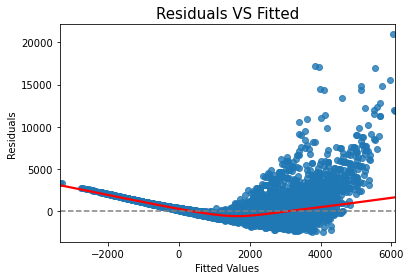

In [120]:
sns.regplot(fitted, resid, lowess = True, line_kws = {'color' : 'red'})
plt.plot([fitted.min(), fitted.max()], [0, 0], '--', color = 'gray')
plt.ylabel('Residuals')
plt.xlabel('Fitted Values')
plt.title('Residuals VS Fitted', size = 15)
plt.show()

잔차 분석 결과 잔차의 추정선이 기울기가 0인 직선과 유사하므로 잔차가 등분산을 만족한다고 할 수 있다.

In [121]:
from scipy.stats import shapiro

In [122]:
s_test = shapiro(resid)
print(f'shapiro의 통계량은 {round(s_test.statistic, 5)}이고 p-value는 {round(s_test.pvalue, 7)}')

shapiro의 통계량은 0.69074이고 p-value는 0.0


In [124]:
from scipy.stats import zscore, probplot
from statsmodels.stats.outliers_influence import OLSInfluence
# OLSInfluence로 호출하는 방식과 result.get_influence()로 호출하는 방식 동일

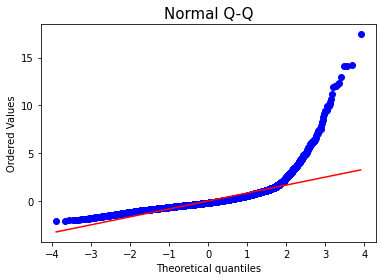

In [125]:
probplot(result.get_influence().resid_studentized_internal, plot = plt)
plt.title('Normal Q-Q', size = 15)
plt.show()

잔차의 정규성은 만족하지 못한다.

In [126]:
sr = zscore(resid)

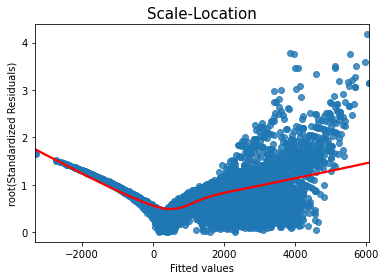

In [127]:
sns.regplot(fitted, np.sqrt(np.abs(sr)), lowess = True, line_kws = {'color': 'red'})
plt.title('Scale-Location', size = 15)
plt.ylabel('root(Standardized Residuals)')
plt.xlabel('Fitted values')
plt.show()

In [128]:
cd, _ = OLSInfluence(result).cooks_distance
cd = cd.sort_values()[::-1][:50]

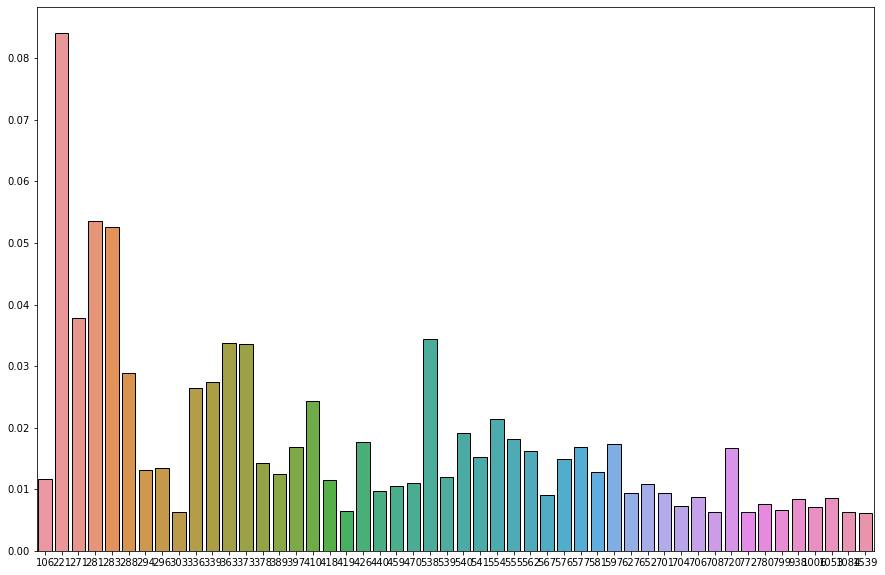

In [129]:
plt.figure(figsize = (15, 10))
sns.barplot(x = cd.index, y = cd, edgecolor = (0, 0, 0))
plt.show()

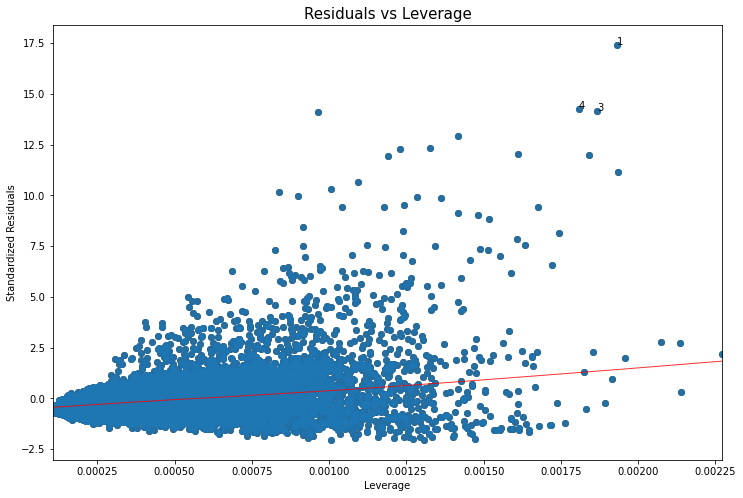

In [130]:
plt.figure(figsize = (12, 8))
plt.scatter(result.get_influence().hat_matrix_diag, sr, color = 'black', alpha = .7)
sns.regplot(result.get_influence().hat_matrix_diag, sr, lowess = True,
              line_kws = {'color': 'red', 'lw': 1, 'alpha': 0.8});
leverage_top_3 = np.flip(np.argsort(result.get_influence().cooks_distance[0]), 0)[:3]
for i in leverage_top_3:
    plt.annotate(i, xy = (result.get_influence().hat_matrix_diag[i], sr[i]));
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.title('Residuals vs Leverage', size = 15)
plt.show()